In [1]:
# 필요한 패키지 import 하기
import os                             # 환경 변수나 디렉터리, 파일 등의 OS 자원을 제어할 수 있게 해주는 모듈
import cv2                            # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
import matplotlib.pyplot as plt       # 다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 라이브러리
import numpy as np                    # 다차원 배열을 쉽게 처리하고 효율적으로 사용할 수 있도록 하는 라이브러리
import dlib                           # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리 
import copy

# Step 1. 파일 불러오기

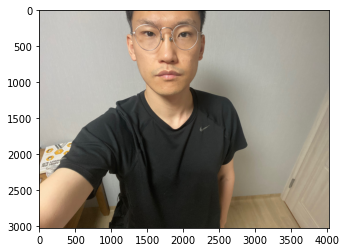

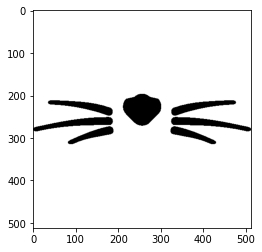

In [2]:
# 나의 사진 및 스티커 경로
image_path = os.getenv("HOME") + "/aiffel/LMS/Exploration/[Exp_07] 스티커앱 만들기/data/test1.jpeg"      
sticker_path = os.getenv("HOME") + "/aiffel/LMS/Exploration/[Exp_07] 스티커앱 만들기/data/mustache.png"


# 이미지 불러오기
img_bgr = cv2.imread(image_path)                              # OpenCV로 이미지를 불러옵니다
img_rgb_original = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)   # OpenCV에서 BRG로 로드된 이미지를 RGB로 변환
img_rgb_show = img_rgb_original.copy()                        # 출력용 이미지를 따로 보관함


# 스티커 불러오기
sticker_bgr = cv2.imread(sticker_path)                             # OpenCV로 스티커를 불러옵니다
sticker_original = cv2.cvtColor(sticker_bgr, cv2.COLOR_BGR2RGB)    # OpenCV에서 BRG로 로드된 스티커를 RGB로 변환
sticker_rgb = sticker_original.copy()


# 이미지, 스티커 출력
plt.imshow(img_rgb_original)                                  # 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
plt.show()                                                    # 이미지를 출력해준다. (실제 출력)      
plt.imshow(sticker_original)                                       # 스티커를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
plt.show()                                                    # 스티커를 출력해준다. (실제 출력)

# Step 2. 얼굴 검출 & 랜드마크 검출

## 얼굴 사각형으로 검출

In [3]:
# 얼굴 찾기
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()    # 기본 얼굴 감지기를 반환
dlib_rects = detector_hog(img_rgb_original, 1)     # (image, upsampling 횟수)

# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)                                  # 찾은 얼굴 영역의 좌표

rectangles[[(1252, 102) (2402, 1252)]]


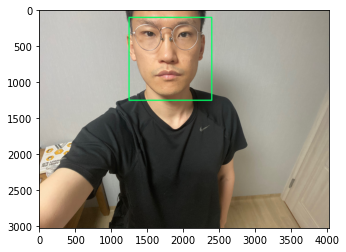

In [4]:
for dlib_rect in dlib_rects:               # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left()                   # 왼쪽
    t = dlib_rect.top()                    # 위쪽
    r = dlib_rect.right()                  # 오른쪽
    b = dlib_rect.bottom()                 # 아래쪽

    cv2.rectangle(img_rgb_show, (l,t), (r,b), (0,255,100), 15, lineType=cv2.LINE_AA)     # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림
                                                                                         # 사각형 왼쪽위 시작점 좌표 : 두 번째 인자
                                                                                         # 사각형 오른쪽 아래 종료점 좌표 : 세 번째 인자
                                                                                         # 컬러 : 네 번째 인자
                                                                                         # 선 두께 : 다섯번째 인자

plt.imshow(img_rgb_show)
plt.show()

## LandMark 검출

In [5]:
# # Dlib은 ibug 300-W 데이터셋으로 학습한 pretrained model 을 제공함
# # 공개되어 있는 weight file을 다운로드 받음
# # 해당 모델파일은 bz2 압축파일 형태로 제공되어 압축을 풀어준 후 사용하겠음
# !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
# !mv shape_predictor_68_face_landmarks.dat.bz2 ~/aiffel/LMS/Exploration/\[Exp_07\]\ 스티커앱\ 만들기/models
# !cd ~/aiffel/LMS/Exploration/\[Exp_07\]\ 스티커앱\ 만들기 && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2  # bzip2 압축파일 푸는 명령어

In [6]:
# 저장한 landmark 모델의 주소를 model_path 변수에 저장
model_path = os.getenv('HOME') + '/aiffel/LMS/Exploration/[Exp_07] 스티커앱 만들기/models/shape_predictor_68_face_landmarks.dat'


# 모델 불러오기
# dlib 라이브러리의 shape_predictor 함수를 이용하여 모델을 불러옴
# dlib.rectangle: 내부를 예측하는 박스
# dlib.full_object_detection: 각 구성 요소의 위치와, 이미지 상의 객체의 위치를 나타냄
# 객체 landmark_predictor는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환합니다.
landmark_predictor = dlib.shape_predictor(model_path)


# 랜드마크의 위치를 저장할 list 생성  
list_landmarks = []
  

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
# face landmark 좌표를 저장해둡니다
for dlib_rect in dlib_rects:
    # 모든 landmark의 위치정보를 points 변수에 저장
    points = landmark_predictor(img_rgb_original, dlib_rect)
    
    # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))       # 얼굴 하나당 하나의 리스트를 만듦      
                                                                        # point 객체에서 x, y를 뽑아 리스트로 변환
    # list_landmarks에 랜드마크 리스트를 저장
    list_landmarks.append(list_points)

    
# 얼굴이 n개인 경우 list_landmarks는 n개의 원소를 갖고
# 각 원소는 68개의 랜드마크 위치가 나열된 list 
# list_landmarks의 원소(얼굴)가 1개이므로 list_landmarks[1]을 호출하면 IndexError가 발생
print(len(list_landmarks[0]))

68


# STEP 3. 스티커 적용 위치 확인하기

In [7]:
# # list_landmarks의 원소(얼굴)가 1개이므로 아래 반복문은 한번만 실행됨
# position_number = 0
# for landmark in list_landmarks:
#     for point in landmark:
#         img_rgb_show_landmark = img_rgb_original.copy()
#         # cv2.circle: OpenCV의 원을 그리는 함수
#         # img_show 이미지 위 각각의 point에
#         # 원의 크기가 2이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
#         # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)
#         cv2.circle(img_rgb_show_landmark, point, 20, (0, 255, 255), -1)
#         cv2.putText(img_rgb_show_landmark, str(position_number), point, cv2.FONT_HERSHEY_SIMPLEX, 10, (255,0,0), 10)
#         plt.figure(figsize=(10, 10))
#         plt.imshow(img_rgb_show_landmark)
#         plt.show()
#         position_number += 1

# STEP 4. 스티커가 적용될 위치를 Landmark를 사용해서 계산하기

(1791, 750)
인중 부위 (x,y) : (1791,750)
사각형 폭, 높이 (w,h) : (1151,1151)


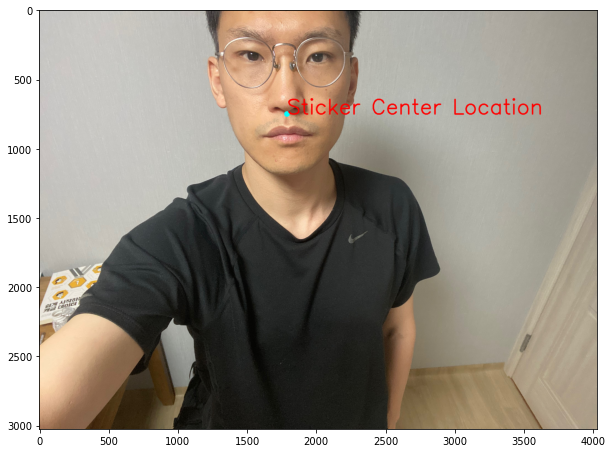

In [8]:
# dlib_rects : 얼굴 영역을 저장하고 있는 값 → rectangles[[(1469, 937) (2427, 1895)]]
# list_landmarks : 68개의 랜드마크 값 저장(이목구비 위치(x,y)) → [[(1417, 1171), (1425, 1310), (1441, 1447), (1469, 1580), (1521, 1700), (1935, 1693), (1890, 1688)]]
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):     # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
    print (landmark[33])                                         # 인중의 index는 33 입니다
    x = landmark[33][0]                                          # 이미지에서 인중 부위의 x값
    y = landmark[33][1]                                          # 이미지에서 인중 부위의 y값
    w = h = dlib_rect.width()                                   # 얼굴 영역의 가로를 차지하는 픽셀의 수 (2427-1469+1) → max(x) - min(x) + 1(픽셀의 수 이기 때문에 1을 더해줌 → 픽셀 수는 점 하나로도 1이 됨)
    print ('인중 부위 (x,y) : (%d,%d)' % (x,y))
    print ('사각형 폭, 높이 (w,h) : (%d,%d)' % (w,h))
    
    img_rgb_show_landmark = img_rgb_original.copy()
    cv2.circle(img_rgb_show_landmark, (x, y), 20, (0, 255, 255), -1)
    cv2.putText(img_rgb_show_landmark, "Sticker Center Location", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 5, (255,0,0), 10)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb_show_landmark)
    plt.show()

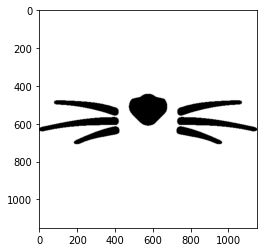

In [9]:
# 스티커 리사이즈
sticker_rgb = cv2.resize(sticker_rgb, (w,h))
plt.imshow(sticker_rgb)

In [10]:
# 스티커 사이즈 조절하기

# x,y,w,h 모두 위에서 반복문 안에서 지정해준 값임
# x는 이미지에서 귀 부위의 x값 = 1927
# y는 이미지에서 귀 부위의 y값 = 1086
# w는 얼굴 영역의 가로를 차지하는 픽셀의 수 = 959
# h는 얼굴 영역의 가로를 차지하는 픽셀의 수 = 959


# 스티커의 왼쪽 위 지점을 이미지 상에 놓을 좌표
# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정합니다. 이미지 시작점은 top-left 좌표이기 때문입니다.
# 즉, refined_x, refined_y 값에서 왕관 이미지가 시작됨
refined_x = x - w // 2                   # 1927 - 959/2= 1927-480 = 1447
refined_y = y - h // 2                       # 1086 - 959 = 127


# 우리는 현재 이마 자리에 왕관을 두고 싶은건데, 이마위치 - 왕관 높이를 했더니 이미지의 범위를 초과하여 음수가 나오는 것
# opencv는 ndarray데이터를 사용하는데, ndarray는 음수인덱스에 접근 불가하므로 스티커 이미지를 잘라 줘야 한다.
print ('스티커 왼쪽 상단을 이미지에 놓을 좌표 (x,y) : (%d,%d)'%(refined_x, refined_y)) # 음수 발생 : 이미지 범위를 벗어남


# 왕관 이미지가 이미지 밖에서 시작하지 않도록 조정이 필요함
# 좌표 순서가 y,x임에 유의한다. (y,x,rgb channel)
# 현재 상황에서는 -y 크기만큼 스티커를 crop 하고, top 의 x좌표와 y 좌표를 각각의 경우에 맞춰 원본 이미지의 경계 값으로 수정하면 아래와 같은 형식으로 나옵니다.
# 음수값 만큼 왕관 이미지(혹은 추후 적용할 스티커 이미지)를 자른다.
if refined_x < 0: 
    sticker_rgb = sticker_rgb[:, -refined_x:]       # 스티커 이미지의 음수 영역를 자름
    refined_x = 0
# 왕관 이미지를 씌우기 위해 왕관 이미지가 시작할 y좌표 값 조정
if refined_y < 0:
    sticker_rgb = sticker_rgb[-refined_y:, :]       # 스티커 이미지의 음수 영역를 자름
                                                    # refined_y가 -98이므로, img_sticker[98: , :]가 된다. 이미지 자체는 행렬이므로 슬라이싱 할때는 98부터해야 함
                                                    # 스티커 이미지 크기 (187, 187, 3)에서 (89, 187, 3)이 됨 (187개 중에서 98개가 잘려나감)
    refined_y = 0                                   # 스티커의 시작지점의 높이를 0으로 변경해야 함

print ('잘려진 스티커의 새로운 왼쪽상단 시작점 (x,y) : (%d,%d)'%(refined_x, refined_y))

스티커 왼쪽 상단을 이미지에 놓을 좌표 (x,y) : (1216,175)
잘려진 스티커의 새로운 왼쪽상단 시작점 (x,y) : (1216,175)


# STEP 5. 스티커 적용하기

(1) 오늘 배운 np.where 를 사용해서 스티커를 적용해 주세요.

(2) 스티커를 조금 더 자연스럽게 보이게 하려면 어떻게 해야 할까요? 스티커 뒤로 원본 이미지가 같이 보이도록 만들어 봅시다. opencv 의 cv2.addWeighted() 를 참고하세요.

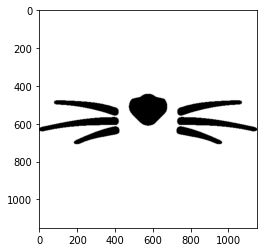

In [11]:
# 확인용
plt.imshow(sticker_rgb)

## 5.1 투명도 적용 아니한 경우

In [12]:
# sticker_attaching_orginal_area 원본이미지에서 스티커를 적용할 위치를 crop한 이미지 입니다.
sticker_attaching_orginal_area = img_rgb_original[refined_y : refined_y+sticker_rgb.shape[0], refined_x : refined_x+sticker_rgb.shape[1]].copy()  # 원본이미지의 크롭 부분
                                                                                                                                                 # 슬라이싱은 얕은 복사 - 주소값만 가져오기, not creating new objects
                                                                                                                                                  # copy는 깊은 복사 - 새로 객체를 만들고 그 객체의 주소를 가져오
img_rgb_show[refined_y:refined_y+sticker_rgb.shape[0], refined_x:refined_x+sticker_rgb.shape[1]] = \
    np.where(sticker_rgb==255, sticker_attaching_orginal_area, sticker_rgb).astype(np.uint8)   # 스티커 이미지 행렬에서 0인 부분은 원본 이미지에서 이미지값을 가져오고 0이 아니면 스티커 이미지에서 이미지 값을 가져오기 
                                                                                             # 슬라이싱이므로 주소값만 가져오는것이라서 =의 왼쪽 코드는 =의 오른쪽 코드를 =의 왼쪽인 원본이미지에 덮어쓰기라는 말

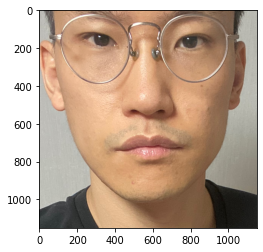

In [13]:
# 원본 이미지 크롭한 영역
plt.imshow(sticker_attaching_orginal_area)

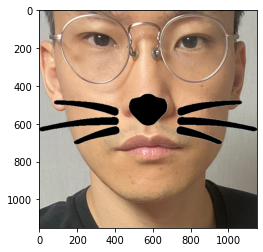

In [14]:
# 원본 크롭 부분과 스티커 합성
plt.imshow(np.where(sticker_rgb==255, sticker_attaching_orginal_area, sticker_rgb).astype(np.uint8))

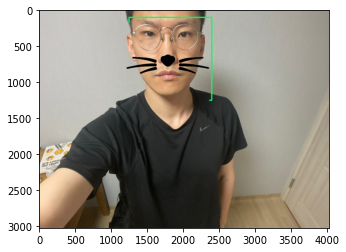

In [15]:
plt.imshow(img_rgb_show)

## 5.2 투명도 적용한 경우

In [16]:
alpha = 0.6
beta = 1 - alpha
img_weighted = cv2.addWeighted(sticker_attaching_orginal_area, alpha, sticker_rgb, beta, 0)

# sticker_attaching_orginal_area 원본이미지에서 스티커를 적용할 위치를 crop한 이미지 입니다.
sticker_attaching_orginal_area = img_rgb_original[refined_y : refined_y+sticker_rgb.shape[0], refined_x : refined_x+sticker_rgb.shape[1]].copy()  # 원본이미지의 크롭 부분
                                                                                                                                                 # 슬라이싱은 얕은 복사 - 주소값만 가져오기, not creating new objects
                                                                                                                                                  # copy는 깊은 복사 - 새로 객체를 만들고 그 객체의 주소를 가져오
img_rgb_show[refined_y:refined_y+sticker_rgb.shape[0], refined_x:refined_x+sticker_rgb.shape[1]] = \
    np.where(sticker_rgb==255, sticker_attaching_orginal_area, img_weighted).astype(np.uint8)   # 스티커 이미지 행렬에서 0인 부분은 원본 이미지에서 이미지값을 가져오고 0이 아니면 스티커 이미지에서 이미지 값을 가져오기 
                                                                                             # 슬라이싱이므로 주소값만 가져오는것이라서 =의 왼쪽 코드는 =의 오른쪽 코드를 =의 왼쪽인 원본이미지에 덮어쓰기라는 말

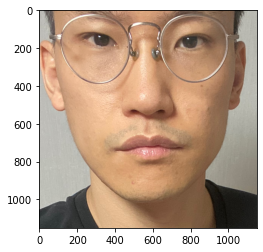

In [17]:
# 원본 이미지 크롭한 영역
plt.imshow(sticker_attaching_orginal_area)

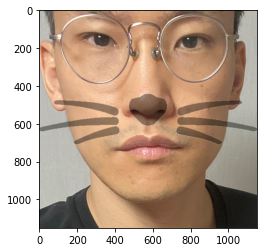

In [18]:
# 원본 크롭 부분과 스티커 합성
plt.imshow(np.where(sticker_rgb==255, sticker_attaching_orginal_area, img_weighted).astype(np.uint8))

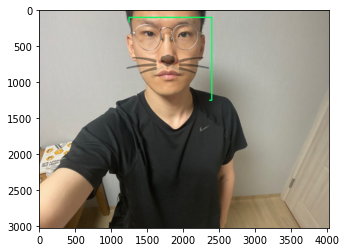

In [19]:
# 원본이미지에 스티커 왕관 붙이기 한 이후 원본 이미지 상태
# 왕관 이미지를 적용한 이미지를 보여준다.
# 얼굴 영역(7-3)과 랜드마크(7-4)를 미리 적용해놓은 img_show에 왕관 이미지를 덧붙인 이미지가 나오게 된다.)
plt.imshow(img_rgb_show)
plt.show()

## 5.3 원본 이미지에 스티커 적용

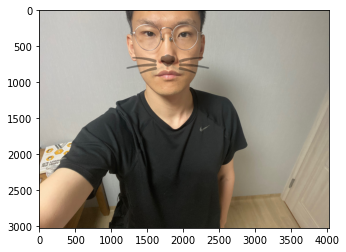

In [20]:
sticker_attaching_orginal_area = img_rgb_original[refined_y : refined_y+sticker_rgb.shape[0], refined_x : refined_x+sticker_rgb.shape[1]].copy()


# img_bgr은 7-2에서 rgb로만 적용해놓은 원본 이미지이다.
img_rgb_original_show = copy.deepcopy(img_rgb_original)
img_rgb_original_show[refined_y:refined_y+sticker_rgb.shape[0], refined_x:refined_x+sticker_rgb.shape[1]] = \
    np.where(sticker_rgb==255, sticker_attaching_orginal_area, img_weighted).astype(np.uint8)
plt.imshow(img_rgb_original_show)                                      # rgb만 적용해놓은 원본 이미지에 왕관 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

# STEP 6. 문제점 찾아보기

(1) 셀프 카메라를 다양한 각도에서 촬영하면서 스티커를 반복해서 적용해 보세요.

(2) 문제점이 무엇인지 최대한 자세하게 기록해 보세요. 여러분이 생각한 문제점을 해결하기 위한 방법은 분명 존재합니다!

> 오늘 만든 스티커앱에서 생각해볼 수 있는 문제점은 다음과 같습니다.  
    - 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?  
    - 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?  
    - 실행 속도가 중요할까요?  
    - 스티커앱을 만들 때 정확도가 얼마나 중요할까요?  


# STEP 7. 회고